In [1]:
import torch
# import tenseal as ts
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
import openfhe
from openfhe import PKESchemeFeature

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

In [3]:
def normalize_data(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


In [4]:
x_train,x_test,y_train,y_test = load_data('date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalize_data(x_train,x_test,y_train,y_test)



############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
class LinearRegressionEncrypted:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = [0.01] * n_features
        # self.weight = np.random.uniform(-self.bound, self.bound, size=n_features).tolist()
        self.bias = np.zeros(n_features).tolist()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0


    def forward_on_encrypted_data(self, enc_x):
        output = []
        i=1
        for x in enc_x:
            enc_sum = cc.EvalInnerProduct(x, self.weight,16)
            enc_pred = cc.EvalAdd(enc_sum, self.bias)
            output.append(enc_pred)
        return output

   
    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        half = 2/batch_size
        delta_y = [cc.EvalSub(out , y) for out, y in zip(enc_out, enc_y)]
        delta_w = [cc.EvalMultAndRelinearize(x , dy) for dy, x in zip(delta_y, enc_x)]
        self._delta_w = cc.EvalAddManyInPlace(delta_w)
        self._delta_w = cc.EvalMult(self._delta_w, half)
        self._delta_b = cc.EvalAddManyInPlace(delta_y)
        self._delta_b = cc.EvalMult(self._delta_b, half)
       

    def update_parameters(self):
        if self._delta_w == 0:
            raise RuntimeError("Trebuie sa treci prin functia forword macar o data")
        self._delta_w = cc.EvalMult(self._delta_w, self.learning_rate)
        prod = cc.EvalMult(self.weight_decay,  self.weight)
        self._delta_w = cc.EvalAdd(self._delta_w, prod) 
        self.weight = cc.EvalSub(self.weight, self._delta_w)
        prod = cc.EvalMult(self._delta_b, self.learning_rate)
        self.bias = cc.EvalSub(self.bias,prod) 

        decr_w= cc.Decrypt(self.weight, keys.secretKey)
        decr_w = decr_w.GetRealPackedValue()
        decr_b = cc.Decrypt(self.bias, keys.secretKey)
        decr_b = decr_b.GetRealPackedValue()
    
        self._delta_w = 0
        self._delta_b = 0
    

    def encrypt(self):
        self.weight = cc.MakeCKKSPackedPlaintext(self.weight)
        self.weight = cc.Encrypt(keys.publicKey, self.weight )
        self.bias = cc.MakeCKKSPackedPlaintext(self.bias)
        self.bias= cc.Encrypt(keys.publicKey, self.bias)
       
    def decrypt(self):
        self.weight = cc.Decrypt(self.weight, keys.secretKey)
        self.weight = self.weight.GetRealPackedValue()
        self.bias = cc.Decrypt(self.bias, keys.secretKey)
        self.bias = self.bias.GetRealPackedValue()
      
       

In [6]:
multDepth = 8
scaleModSize = 50
batchSize = len(x_test[1]) #16
parameters = openfhe.CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
# parameters.SetScalingTechnique(openfhe.ScalingTechnique.FLEXIBLEAUTO)
parameters.SetFirstModSize(60)

parameters.SetRingDim(4096)
parameters.SetSecurityLevel(openfhe.HEStd_NotSet)

cc = openfhe.GenCryptoContext(parameters)

cc.Enable(PKESchemeFeature.PKE)
cc.Enable(PKESchemeFeature.KEYSWITCH)
cc.Enable(PKESchemeFeature.LEVELEDSHE)
cc.Enable(PKESchemeFeature.ADVANCEDSHE)
cc.Enable(PKESchemeFeature.FHE)
ring_dim = cc.GetRingDimension()
security_param= parameters.GetSecurityLevel()
keys = cc.KeyGen()

cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)

print(f"ring dim: {parameters.GetRingDim()}")


ring dim: 4096


In [46]:
print(x_train.shape)
x_train_list = x_train[:1000].tolist() 
print(x_train_list[:2])
print(type(x_train_list[0]))

print(y_train.shape)
y_train_list = y_train[:1000].tolist() 
print(y_train_list[:2])
print(type(y_train_list[0]))


print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))


torch.Size([24500, 16])
[[0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, -0.4097440242767334, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156], [0.38178399205207825, 0.9948703050613403, -0.4117799401283264, -0.5782929062843323, 3.0457913875579834, -0.48778727650642395, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, 2.3989360332489014, -0.33037757873535156]]
<class 'list'>
torch.Size([24500, 1])
[[-0.6384840607643127], [1.2037829160690308]]
<class 'list'>
torch.Size([10500, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.412728607654

In [8]:
def encrypt_vector(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [9]:
t_start = time.perf_counter()
enc_x_train = encrypt_vector(x_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:12<00:00, 82.71it/s]

encryption took: 12.099099912999009


In [47]:
t_start = time.perf_counter()
enc_x_test = encrypt_vector(x_test_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 700/700 [00:06<00:00, 109.72it/s]

encryption took: 6.385554546999629


In [10]:
def encrypt_vector_y(lista):
    enc_list=[]
    for x_t_l in tqdm(lista, desc="data encryption"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l*16)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [11]:
t_start = time.perf_counter()
enc_y_train = encrypt_vector_y(y_train_list)
t_end = time.perf_counter()
print(f"encryption took: {t_end-t_start}")

data encryption: 100%|██████████| 1000/1000 [00:11<00:00, 89.76it/s]

encryption took: 11.144725987998754


In [12]:
print(cc.Decrypt(enc_y_train[0],keys.secretKey))

(-0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484, -0.638484,  ... ); Estimated precision: 44 bits



In [13]:
def save_model(model,file_path):
    pickle.dump(model, open(file_path, "wb"))


In [14]:
def forward_test(model, x_test):
    w = torch.tensor(model.weight)
    b = torch.tensor(model.bias)
    out = (x_test.matmul(w) + b[0]).reshape(-1, 1)
    return out

In [15]:
y = y_test[:700].detach().numpy()

In [16]:
len(enc_x_train)

1000

In [ ]:
model = LinearRegressionEncrypted(x_train.shape[1])

In [28]:
# model = LinearRegressionEncrypted(x_train.shape[1])
batch_size = 512
t_start = time.perf_counter()
for epoch in tqdm(range(5),desc="epoch"):
    t_start_epoch = time.perf_counter()
    indices = np.random.permutation(len(enc_x_train))
    epoch_data = [enc_x_train[idx] for idx in indices]
    epoch_targets = [enc_y_train[idx] for idx in indices]


    for batch in range(0, len(epoch_data),batch_size):
        model.encrypt()
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]

        batch_out = model.forward_on_encrypted_data(batch_data)
        model.backward(batch_data, batch_out, batch_targets)
        model.update_parameters()
        model.decrypt()
    
    pred = forward_test(model,x_test[:700])
    t_end = time.perf_counter()

    pred = pred.detach().numpy()
    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")
t_end = time.perf_counter()

save_model(model,'li_r_trained_on_clear_data.pkl')


epoch:  20%|██        | 1/5 [01:18<05:14, 78.72s/it]

R^2 Score = 0.8328
MSE = 0.1728


epoch:  40%|████      | 2/5 [02:35<03:52, 77.42s/it]

R^2 Score = 0.8423
MSE = 0.1630


epoch:  60%|██████    | 3/5 [03:56<02:38, 79.35s/it]

R^2 Score = 0.8505
MSE = 0.1545


epoch:  80%|████████  | 4/5 [05:15<01:18, 78.96s/it]

R^2 Score = 0.8576
MSE = 0.1471


epoch: 100%|██████████| 5/5 [06:39<00:00, 79.83s/it]

R^2 Score = 0.8639
MSE = 0.1407


In [32]:
def metrici_date_test_clare(model, x, y):
    t_start = time.perf_counter()
    pred = forward_test(model,x)
    t_end = time.perf_counter()
    print(f"predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Valori Reale vs. Predicții', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("./li_r_trained_on_encrypted_data_predictions_on_clear_data.png")
    plt.show()
    return r2,mse

predictiile pe testul de date necriptate au durat:0.00150273299914260861 secunde
R^2 Score = 0.8546
MSE = 0.1539


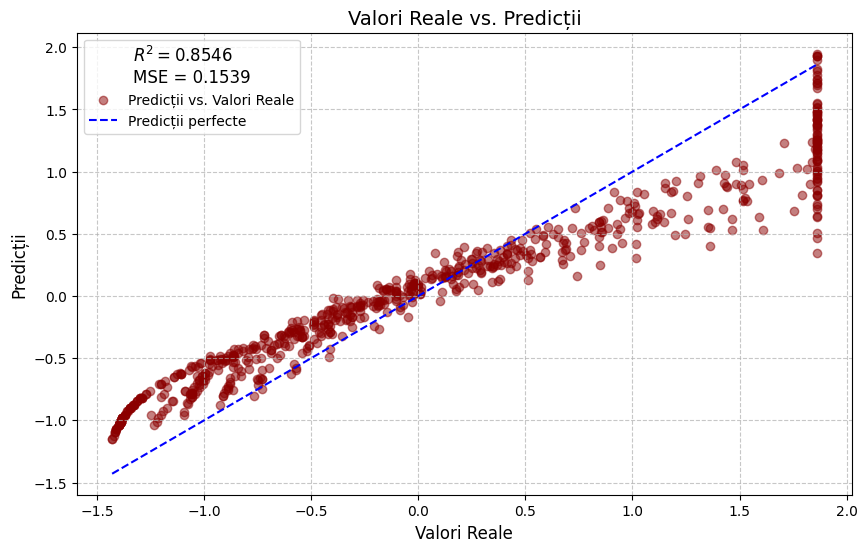

In [56]:
r2_clear,mse= metrici_date_test_clare(model,x_train[:700], y_train[:700])

In [43]:
def importanta_caracteristicilor(model, feature_names):
    weights = model.weight
    print(weights)

    weights = np.abs(weights)
    weights = weights / np.sum(weights)

    sorted_indices = np.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_encrypted_data_feature_importance.png")
    plt.show()



['age', 'gender', 'chest_pain', 'high_blood_pressure', 'irregular_heartbeat', 'shortness_of_breath', 'fatigue_weakness', 'dizziness', 'swelling_edema', 'neck_jaw_pain', 'excessive_sweating', 'persistent_cough', 'chest_discomfort', 'cold_hands_feet', 'snoring_sleep_apnea', 'anxiety_doom']
[0.318981371899191, -0.05569493230695552, 0.1320653951418067, 0.18002749125333847, 0.10060219127095762, 0.10748325846273575, 0.10015684691578322, 0.10022486518052237, 0.07534473184389882, 0.08974874091218629, 0.05025884155024478, 0.06745591221810096, 0.10129835931473194, 0.07739564731283728, 0.11555444737569096, 0.042227328673983766]


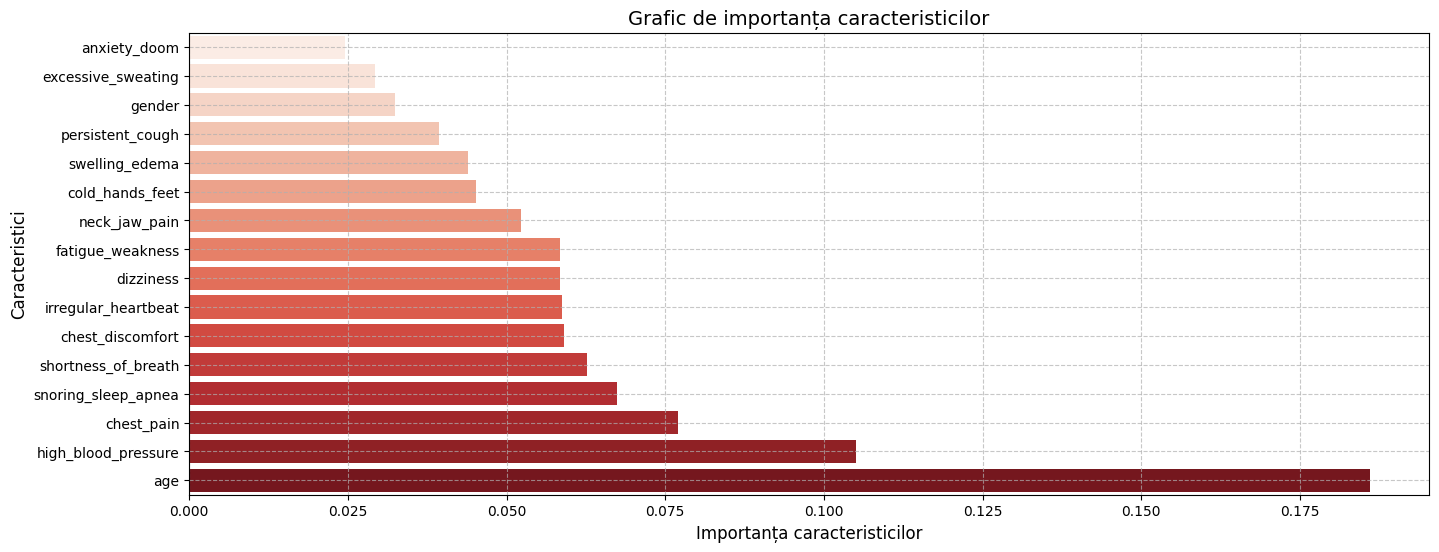

In [44]:
csv = pd.read_csv('./stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()
print(header)
importanta_caracteristicilor(model,header) 

In [53]:
def metrici_date_test_criptate(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    t_start = time.perf_counter()
    model.encrypt()
    enc_list_pred = model.forward_on_encrypted_data(enc_x)
    model.decrypt()
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    print(list_pred[0])
    print(list_pred[0].real)
    # list_pred = [x.real for x in list_pred]
    print(list_pred[0])
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Valori Reale vs. Predictii', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("./li_r_trained_on_encrypted_data_predictions_on_encrypted_data.png")
    plt.show()
    return r2

Predictiile pe testul de date criptat au durat:47.46606072199938353151 secunde
Decriptarea predictiilor a durat:4.50986226200075179804 secunde
0.19454080993540573
0.19454080993540573
0.19454080993540573
R^2 Score = 0.8639
MSE = 0.1407


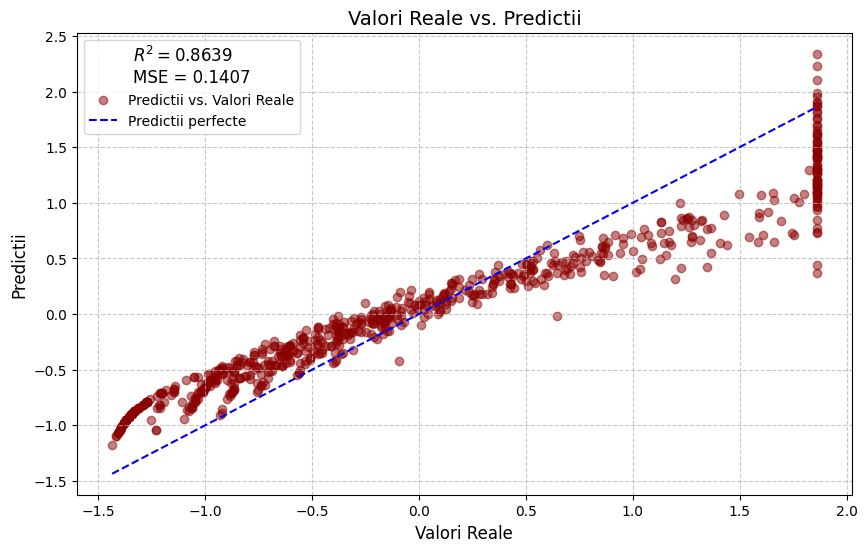

In [55]:
r2_enc = metrici_date_test_criptate(model,enc_x_test,y_test[:700])